In [4]:
import torch
import numpy as np
from ffn_relu import ParametricReLUNet


In [5]:
def sample_covariance(neuron_one, trainpoint_one, neuron_two, trainpoint_two, yy):
    '''Sample covariance, formulas as in https://en.wikipedia.org/wiki/Sample_mean_and_covariance'''
    one = yy[:, neuron_one-1, trainpoint_one-1]
    two = yy[:, neuron_two-1, trainpoint_two-1]
    cov = np.cov(one, two)[0, 1]

    return cov


In [6]:
#Test for PReLU-activation implementation
testPReLU = ParametricReLUNet()
testPReLU.set_slopes(0.5, 0.2)
resultPReLU = testPReLU.PReLU(torch.tensor(np.array([1.1,-2.2]), dtype=torch.float32))
print(resultPReLU)

FeedForwardNet created with n0=3, nk=10, nl=3, l=3, bias_on=False
tensor([ 0.5500, -0.4400])


In [7]:
'''n0: # dimension of x
    nk: # hidden nodes
    nl: # dimension of y
    l: # number of layers
    nd: # number of points in train-set'''
n0,nk,nl,l=3,10000,2,20
nd = 2
'''slope_plus, slope_minus: # slopes for Relu
    experiments_number: # number of experiments'''
slope_plus, slope_minus=1.0, 0.5
experiments_number = 200

testNet = ParametricReLUNet(n0=n0,nk=nk,nl=nl,l=l)
testNet.set_log_level("info")
testNet.set_slopes(slope_plus, slope_minus)
testNet.set_gmetric_recording_indices([(1,1),(1,2),(2,2)])

xx = np.random.normal(size=(n0, nd)).astype(np.float32)
yy = np.zeros((experiments_number, nl, nd))
#weights distribution variances are set as in (5.67)
cb, cw = 0, 2.0/(slope_plus**2.0 + slope_minus**2.0)

G01_records = []
G00_records = []
G11_records = []

#for each experiment re-initialisation of the weights with recalculation
for experiment_number in range(experiments_number):
    testNet.init_weights(cb, cw)
    res = testNet.forward(xx)
    yy[experiment_number] = res
    G00_records.append(testNet.get_gmetric(1,1).copy())
    G11_records.append(testNet.get_gmetric(2,2).copy())
    G01_records.append(testNet.get_gmetric(1,2).copy())
    
    print('-', end='')


FeedForwardNet created with n0=3, nk=10000, nl=2, l=10, bias_on=False


----------------------------------------------------------------------------------------------------

In [10]:
for trainpoint1 in range(1, nd+1):
    for trainpoint2 in range(trainpoint1, nd+1):
        print("Metric (4.8) for trainpoint {} and trainpoint {}: {}"\
              .format(trainpoint1, trainpoint2, ParametricReLUNet.G_xx(xx[:,trainpoint1-1], xx[:,trainpoint2-1], cb, cw)))

Metric (4.8) for trainpoint 1 and trainpoint 1: 0.1226409435272217
Metric (4.8) for trainpoint 1 and trainpoint 2: 0.13932140668233237
Metric (4.8) for trainpoint 2 and trainpoint 2: 1.8868204752604167


In [8]:
for neuron1 in range(1, nl+1):
      for neuron2 in range(neuron1, nl+1):
            for trainpoint1 in range(1, nd+1):
                  for trainpoint2 in range(1 if neuron1 != neuron2 else trainpoint1, nd+1):
                        print("Sample covariance between neuron {}, trainpoint {} and neuron {}, trainpoint {}: {}"\
                              .format(neuron1, trainpoint1, neuron2, trainpoint2\
                                      , sample_covariance(neuron1,trainpoint1,neuron2,trainpoint2,yy)))

Sample covariance between neuron 1, trainpoint 1 and neuron 1, trainpoint 1: 0.10996754267277697
Sample covariance between neuron 1, trainpoint 1 and neuron 1, trainpoint 2: 0.17452759248001543
Sample covariance between neuron 1, trainpoint 2 and neuron 1, trainpoint 2: 1.3350442461554264
Sample covariance between neuron 1, trainpoint 1 and neuron 2, trainpoint 1: 0.015744809351269595
Sample covariance between neuron 1, trainpoint 1 and neuron 2, trainpoint 2: 0.051539388518427584
Sample covariance between neuron 1, trainpoint 2 and neuron 2, trainpoint 1: 0.029166971377338532
Sample covariance between neuron 1, trainpoint 2 and neuron 2, trainpoint 2: 0.021687044218710268
Sample covariance between neuron 2, trainpoint 1 and neuron 2, trainpoint 1: 0.10662034778041042
Sample covariance between neuron 2, trainpoint 1 and neuron 2, trainpoint 2: 0.1523106767055808
Sample covariance between neuron 2, trainpoint 2 and neuron 2, trainpoint 2: 1.5773537508585003


In [11]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'G01')

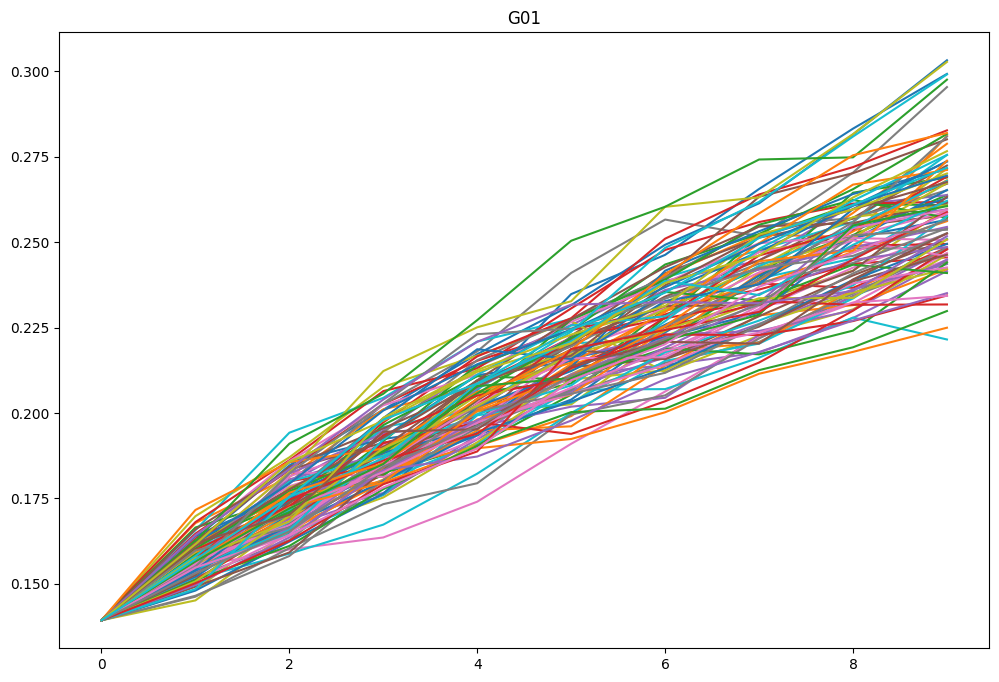

In [12]:
plt.figure(figsize=(12, 8))
for i, Gs in enumerate(G01_records):
    plt.plot(Gs, label=f"experiment {i}")
#plt.legend()
plt.title("G01")

Text(0.5, 1.0, 'G00')

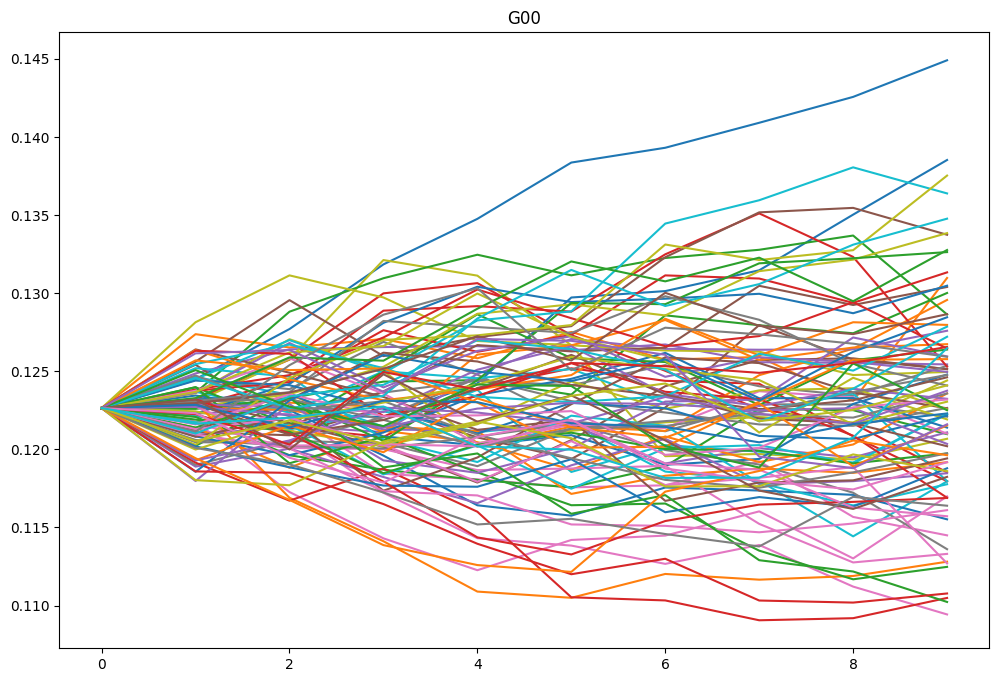

In [13]:
plt.figure(figsize=(12, 8))
for i, Gs in enumerate(G00_records):
    plt.plot(Gs, label=f"experiment {i}")
#plt.legend()
plt.title("G00")

Text(0.5, 1.0, 'G11')

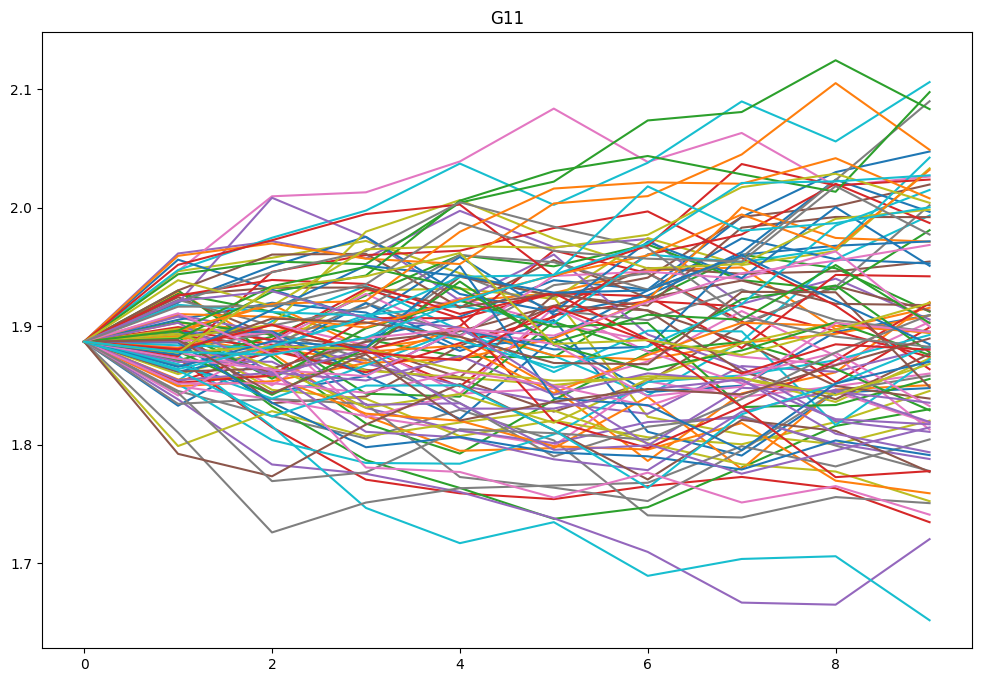

In [14]:
plt.figure(figsize=(12, 8))
for i, Gs in enumerate(G11_records):
    plt.plot(Gs, label=f"experiment {i}")
#plt.legend()
plt.title("G11")